### Implementing a research paper techniques for n-gram language modeling
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf


Curse of dimentionality-- When the vocabulary size is large (e.g., millions of tokens), the output layer of the language model needs to predict the probability distribution over all possible tokens in the vocabulary. This means that the model has to estimate probabilities for a large number of classes, which can make training more challenging.


The function has parameters that can be iteratively tuned in order to maximize the log-likehood of the training data.

<!-- Architecture of the model:
3 words input -> embeddings -> MLP -> 1 word prediction -->

<!-- Regularization techniques used: -->
<!-- - Weight decay -->

<!-- 

- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work? 

-->

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [141]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(".".join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {c:i for i,c in stoi.items()}

In [142]:
# Build dataset

def build_dataset(n, data, splits):
  X, Y = [], []
  for w in data:
    padding = [0]*n
    for ch in w + '.':
      ix = stoi[ch]
      X.append(padding)
      Y.append(ix)
      padding = padding[1:] + [ix] #sliding window
  X,Y = torch.tensor(X),torch.tensor(Y)
  tr, va, te = splits
  tr = int(X.shape[0]*0.8)
  va = int(X.shape[0]*0.1)

  xtrain, ytrain = X[:tr], Y[:tr]
  xvalid, yvalid = X[tr:tr+va], Y[tr:tr+va]
  xtest, ytest = X[tr+va:], Y[tr+va:]
  return [xtrain, ytrain, xvalid, yvalid, xtest, ytest]

xtrain, ytrain, xvalid, yvalid, xtest, ytest = build_dataset(n=3, data=words, splits=(0.8, 0.1, 0.1))

In [143]:
# Hyperparameters
n = 3 # trigram model
emb_sz = 2
n_hidden = 100
vocab_sz = len(chars) # it's 27

# --------------------------------------------------

# embedding matrix -> Hidden layer -> output layer
C  = torch.rand(vocab_sz, emb_sz)
w1 = torch.rand(n*emb_sz, n_hidden)
b1 = torch.rand(n_hidden)
w2 = torch.rand(n_hidden, vocab_sz)
b2 = torch.rand(vocab_sz)

# Setting up gradient requirements
parameters = [C, w1, b1, w2, b2]
for p in parameters:
  p.requires_grad = True

In [144]:
sum([p.nelement() for p in parameters]) # number of neurons (good to know)

3481

In [145]:
# finding a good learning rate

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [146]:
lri = []
lossi = []
perpi = []
stepi = []

In [151]:
epoch = 20000
bs = 250 # batch sz
wd = 0.001 # weight decay

for i in range(epoch):
  if i < epoch*0.4: # 40% of epoch with lr 0.1
    lr = 0.01
  else: lr = 0.001 # lr decay

  idx = torch.randint(0, xtrain.shape[0], size=(bs,))

  emb = C[xtrain[idx]]
  h = torch.tanh(emb.view(emb.shape[0], -1) @ w1 + b1)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, ytrain[idx])

  for p in parameters: 
    p.grad = None
  loss.backward()
  perplexity = torch.exp(loss)
 
  # lr = lrs[i] # to find lr, we change it everytime and plot

  if i < epoch*0.4:
    for p in parameters:
      p.data -= p.grad.data * lr
  else:
    for p in parameters:
      p.grad += 2*p.data*wd
      p.data -= p.grad.data * lr
  
  
  # track
  # lri.append(lr)
  # stepi.append(i)
  lossi.append(loss.item())
  perpi.append(perplexity.item())
  
  print(f"epoch: {i+1}/{epoch} | loss: {loss.item():.4f} | perplexity: {perplexity.item():.4f}")

epoch: 1/20000 | loss: 2.5137 | perplexity: 12.3511
epoch: 2/20000 | loss: 2.5892 | perplexity: 13.3186
epoch: 3/20000 | loss: 2.5302 | perplexity: 12.5560
epoch: 4/20000 | loss: 2.5319 | perplexity: 12.5769
epoch: 5/20000 | loss: 2.6064 | perplexity: 13.5506
epoch: 6/20000 | loss: 2.4996 | perplexity: 12.1776
epoch: 7/20000 | loss: 2.5425 | perplexity: 12.7111
epoch: 8/20000 | loss: 2.5643 | perplexity: 12.9917
epoch: 9/20000 | loss: 2.5512 | perplexity: 12.8230
epoch: 10/20000 | loss: 2.5322 | perplexity: 12.5806
epoch: 11/20000 | loss: 2.4926 | perplexity: 12.0929
epoch: 12/20000 | loss: 2.6305 | perplexity: 13.8804
epoch: 13/20000 | loss: 2.6034 | perplexity: 13.5099
epoch: 14/20000 | loss: 2.5524 | perplexity: 12.8379
epoch: 15/20000 | loss: 2.3487 | perplexity: 10.4724
epoch: 16/20000 | loss: 2.5287 | perplexity: 12.5378
epoch: 17/20000 | loss: 2.5427 | perplexity: 12.7145
epoch: 18/20000 | loss: 2.6481 | perplexity: 14.1277
epoch: 19/20000 | loss: 2.5103 | perplexity: 12.3081
ep

In [152]:
# total loss

emb = C[xvalid]
h = torch.tanh(emb.view(xvalid.shape[0], -1) @ w1 + b1)
logits = h@w2 + b2

loss = F.cross_entropy(logits, yvalid)
loss.item()


2.5899620056152344

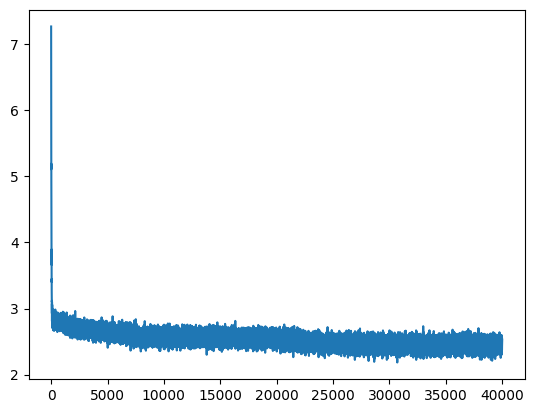

In [153]:
# plt.ylim(0,5)
# plt.xlim(0.0022222,0.15555)
plt.plot(lossi)

# less noise at 0.08

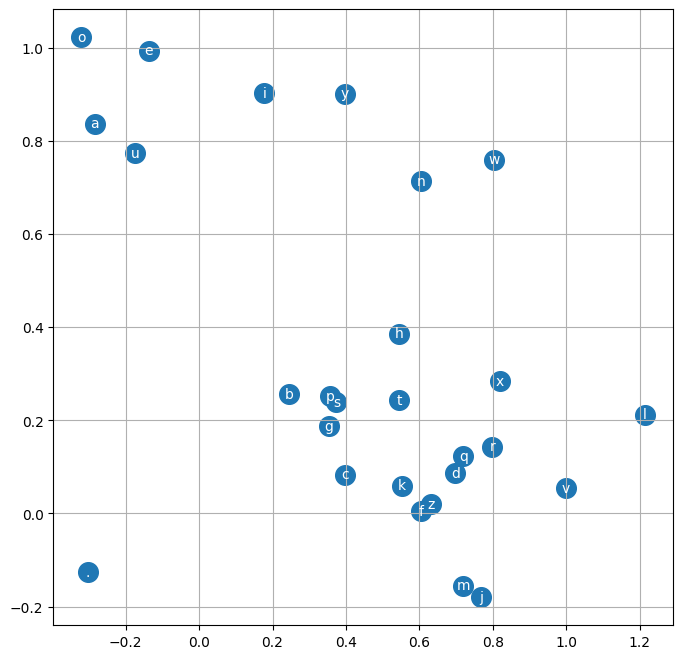

In [154]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')